Ejemplo [datahacker.rs](https://www.youtube.com/watch?v=0BYECoI-v2c)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


In [2]:
transform = transforms.ToTensor()

data_path = '.../data_cifar/'
cifar10_train = datasets.CIFAR10(data_path,train=True,download=True,transform=transform)
cifar10_test = datasets.CIFAR10(data_path,train=False,download=True,transform=transform)

100%|██████████| 170M/170M [00:12<00:00, 14.2MB/s]


In [3]:
print('Training:',len(cifar10_train))
print('Test',len(cifar10_test))

Training: 50000
Test 10000


In [4]:
type(cifar10_train)

torchvision.datasets.cifar.CIFAR10

In [5]:
type(cifar10_test)

torchvision.datasets.cifar.CIFAR10

In [6]:
cifar10_train[0]

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

Tuple with two items, first item 32x32 picture image, and the label.

In [7]:
image,label = cifar10_train[0]
type(image)

torch.Tensor

In [8]:
image.shape

torch.Size([3, 32, 32])

[number of channels,height,width]

In [9]:
print(label)

6


In [10]:
classes = cifar10_train.classes
print(classes)
print(label)
print(classes[label])

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
6
frog


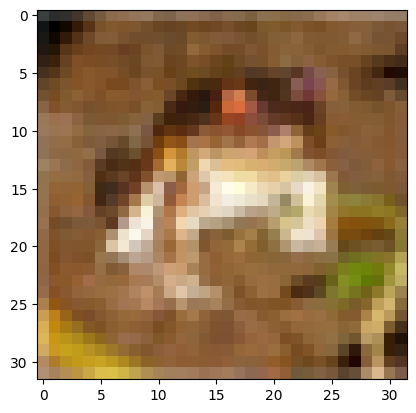

In [11]:
plt.imshow(image.permute(1,2,0))

In [12]:
torch.manual_seed(80)
train_loader = DataLoader(cifar10_train,batch_size=100,shuffle=True)
test_loader = DataLoader(cifar10_test,batch_size=500,shuffle=False)

In [13]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size = 32*32*3,output_size = 10):
        super().__init__()
        self.fc1 = nn.Linear(input_size,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,output_size)

    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)


In [14]:
model = MultiLayerPerceptron()
print(model)

MultiLayerPerceptron(
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [15]:
for param in model.parameters():
    print(param.numel())

368640
120
10080
84
840
10


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

In [17]:
for images, labels in train_loader:
    break

In [18]:
images.shape

torch.Size([100, 3, 32, 32])

$$ [batch,channels,height,width] $$

In [19]:
# Correct shape
images.view(-1,3072).shape

torch.Size([100, 3072])

In [23]:
import time
start_time = time.time()

epochs = 10
train_losses = []
train_correct = []
test_losses = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # --------- Entrenamiento----------------
    for b_iter, (X_train,y_train) in enumerate(train_loader):
        b_iter += 1
        y_pred = model(X_train.view(100,-1)) # 32*32*3
        loss = criterion(y_pred,y_train)

        predicted = torch.max(y_pred.data,1)[1] # [1] Label of the value
        #[0] : Actual values
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if b_iter % 100 == 0:
        accuracy = trn_corr.item()*100/(100*b_iter)
        print(f'Epoch:{i+1},Batch:{b_iter},Loss:{loss.item()},accuracy: {accuracy}')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    with torch.no_grad():
        for b_iter, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500,-1)) # (batch_size,-1)
            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val,y_test)
        test_losses.append(loss.item())
        test_correct.append(tst_corr.item())

total_time = time.time()-start_time
print(f'Duration: {total_time/60} mins')


Epoch:1,Batch:500,Loss:1.6275696754455566,accuracy: 42.798
Epoch:2,Batch:500,Loss:1.7338639497756958,accuracy: 43.712
Epoch:3,Batch:500,Loss:1.5699347257614136,accuracy: 44.382
Epoch:4,Batch:500,Loss:1.5344171524047852,accuracy: 45.12
Epoch:5,Batch:500,Loss:1.5634568929672241,accuracy: 45.478
Epoch:6,Batch:500,Loss:1.4960626363754272,accuracy: 46.042
Epoch:7,Batch:500,Loss:1.4389914274215698,accuracy: 46.518
Epoch:8,Batch:500,Loss:1.5466346740722656,accuracy: 47.06
Epoch:9,Batch:500,Loss:1.5149856805801392,accuracy: 47.328
Epoch:10,Batch:500,Loss:1.6402390003204346,accuracy: 47.952
Duration: 2.1330716689427693 mins


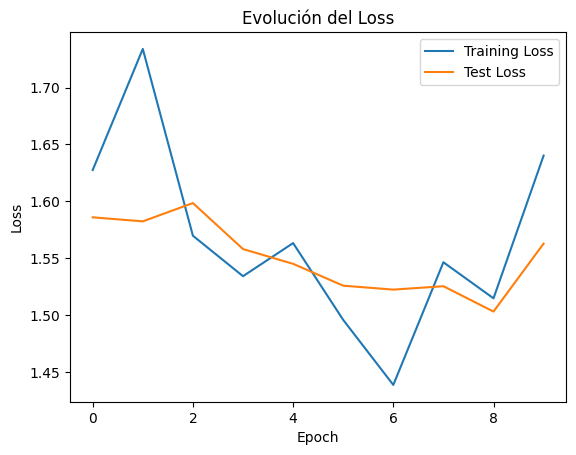

In [24]:
plt.plot(train_losses,label='Training Loss')
plt.plot(test_losses,label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolución del Loss')
plt.legend()
plt.show()

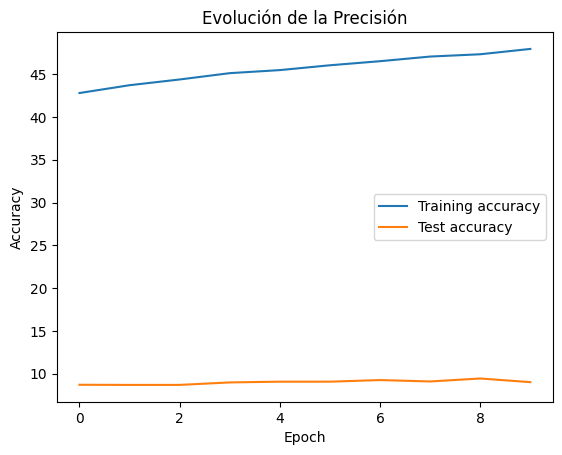

In [25]:
train_accuracy = [t/500 for t in train_correct]
test_accuracy = [t/500 for t in test_correct]
plt.plot(train_accuracy,label='Training accuracy')
plt.plot(test_accuracy,label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolución de la Precisión')
plt.legend()
plt.show()

In [27]:
test_load_all = DataLoader(cifar10_test,batch_size=10000,shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test),-1)) # (batch_size,-1)
        predicted = torch.max(y_val.data,1)[1]
        correct += (predicted == y_test).sum()
    print(100*correct.item()/len(cifar10_test))

45.08


In [29]:
confusion_matrix(predicted.view(-1),y_test.view(-1))

array([[485,  15,  91,  37,  66,  28,  10,  33,  87,  22],
       [141, 818, 101, 142,  74, 112,  93, 108, 201, 418],
       [ 25,   2, 198,  44,  74,  44,  31,  35,   3,   3],
       [ 17,  13, 116, 329,  63, 218, 117,  63,  21,  22],
       [ 30,   8, 152,  41, 361,  56, 104,  71,   8,   4],
       [ 10,  10,  61, 141,  43, 296,  39,  46,  12,   8],
       [ 22,  10, 139, 110, 155,  90, 534,  41,   7,  20],
       [ 22,  15,  72,  41,  96,  82,  32, 475,  11,  25],
       [191,  41,  44,  46,  39,  45,  22,  25, 600,  66],
       [ 57,  68,  26,  69,  29,  29,  18, 103,  50, 412]])

In [31]:
img = image.view(1,-1)

with torch.no_grad():
    model_prediction = model.forward(img)

[0.03924466 0.11245363 0.04830598 0.11801007 0.1184809  0.11964099
 0.31253517 0.11311029 0.00040623 0.01781206]


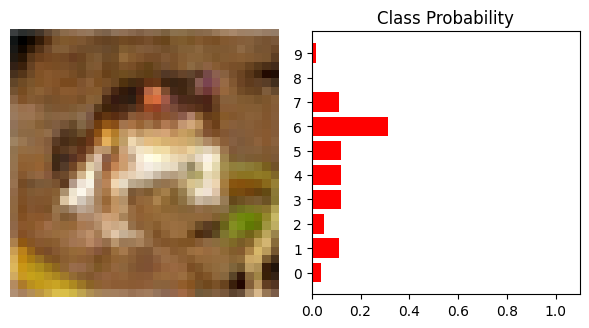

In [32]:
probabilities = F.softmax(model_prediction, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
img = img.view(3, 32, 32)
ax1.imshow(img.permute(1, 2, 0).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

In [33]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [35]:
test_load_all = DataLoader(cifar10_test,batch_size=64,shuffle=False)

images,labels = next(iter(test_load_all))

with torch.no_grad():
    images,labels = images,labels
    preds = model(X_test.view(len(X_test),-1))
images_np = [i.mean(dim=0).cpu().numpy() for i in images]
class_names = cifar10_test.classes

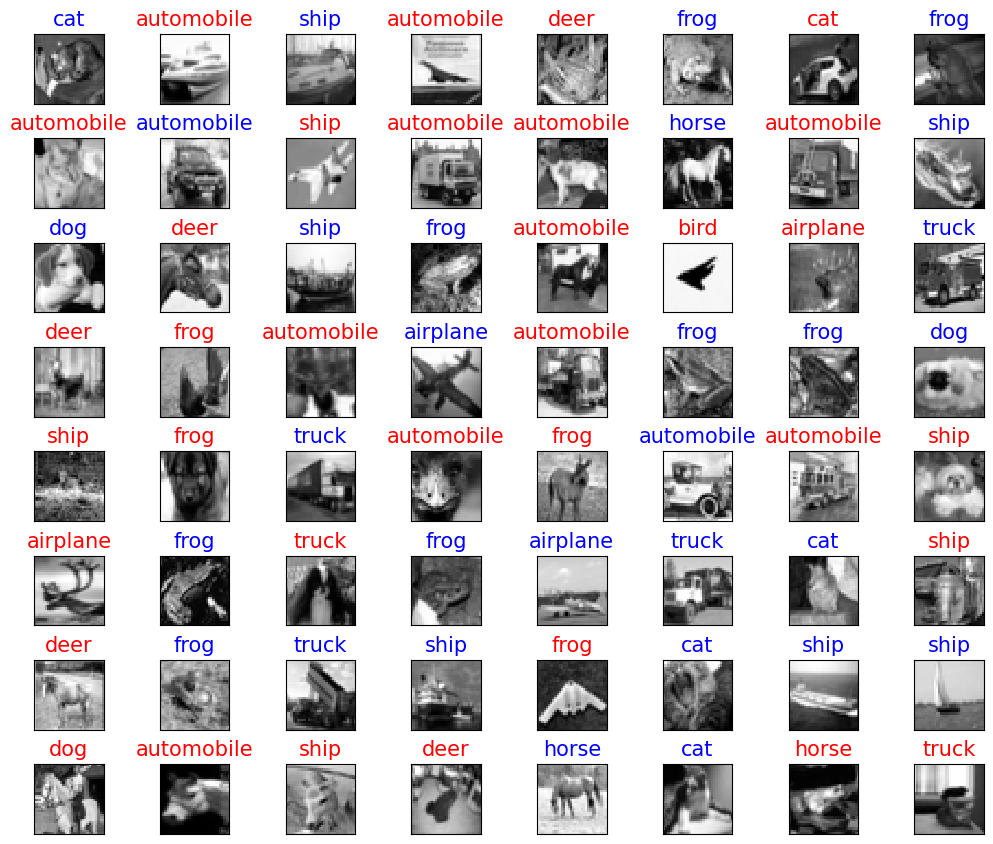

In [36]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)

for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i], cmap='gray', interpolation='nearest')
    color = "blue" if labels[i] == torch.max(preds[i], 0)[1] else "red"
    plt.title(class_names[torch.max(preds[i], 0)[1]], color=color, fontsize=15)